In [401]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from tqdm import tqdm

edges = cv.Canny(img, 100, 200)

In [402]:
clock = cv2.imread("clock_clean.jpg")
clock = cv2.cvtColor(clock, cv2.COLOR_BGR2GRAY)

(-0.5, 499.5, 499.5, -0.5)

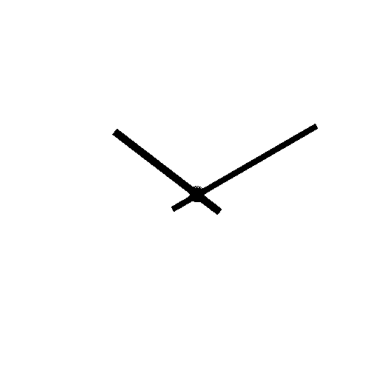

In [403]:
_, clock = cv2.threshold(clock, 127, 255, cv2.THRESH_BINARY)
plt.imshow(clock, cmap="gray")
plt.axis("off")

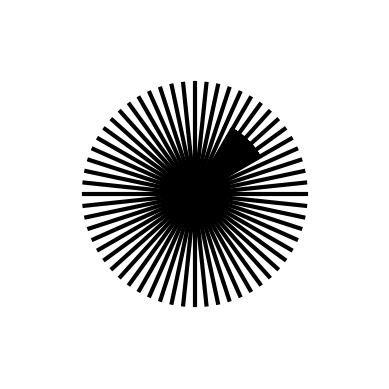

In [404]:
def generate_clock(h, m) -> BytesIO:
    """
    Generates a clockface for a given hour and minute.
    """
    h_r = 0.4
    m_r = 0.6

    h_ang = (np.pi / 2 + (-h / 12) * 2 * np.pi - ((2 * np.pi) / 12) * (m/60))
    m_ang = (np.pi / 2 + (-m / 60) * 2 * np.pi)

    h_x = h_r * np.cos(h_ang)
    h_y = h_r * np.sin(h_ang)

    m_x = m_r * np.cos(m_ang)
    m_y = m_r * np.sin(m_ang)

    plt.plot([0, h_x], [0, h_y], "black", linewidth=3)
    plt.plot([0, m_x], [0, m_y], "black", linewidth=3)

    plt.axis("square")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axis("off")

    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight', pad_inches=0)
    return buf

# test some times on the clock
for i in range(60):
    generate_clock(1, i)


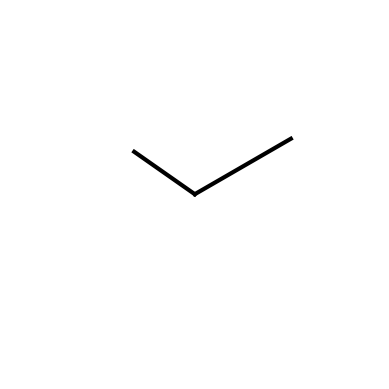

In [405]:
generate_clock(10, 10)

In [397]:
def mse(imgA, imgB):
    err = np.sum((imgA.astype("float") - imgB.astype("float")) ** 2)
    err /= float(imgA.shape[0] * imgA.shape[1])
    return err

In [398]:
def buf2img(buf):
    buf.seek(0)
    img = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)
    return img

100%|██████████| 720/720 [01:16<00:00,  9.44it/s]


best guess: (0, 0, 64046.37832418975)


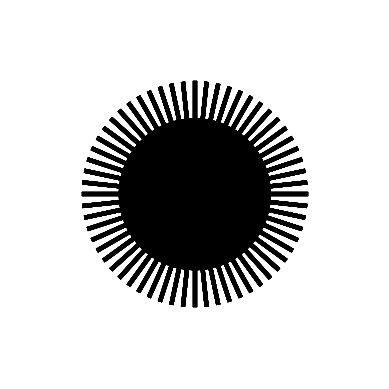

In [399]:
# h, m, err
best_guess = (None, None, float("inf"))

buf = generate_clock(0, 0)
generated_clock = buf2img(buf)

width, height = generated_clock.shape

clock = cv2.resize(clock, (width, height))

with tqdm(total=12*60) as pbar:
    for h in range(0, 12):
        for m in range(0, 60):
            pbar.update(1)

            buf = generate_clock(h, m)
            generated_clock = buf2img(buf)

            err = mse(clock, generated_clock)
            if err < best_guess[2]:
                best_guess = (h, m, err)

print("best guess:", best_guess)